In [42]:
import numpy as np
import pandas as pd
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'sans-serif',
    'text.usetex': False,
    'pgf.rcfonts': False
})

import matplotlib.pyplot as plt
from poliastro.bodies import Earth
from tqdm import tqdm
from astropy import units as u
from notebooks.PlotUtil import apply_report_formatting


figures_dir = 'D:/git/thesis_report_ae/figures'

def generate_pass_df(instance_df):
    starts = instance_df.groupby(['p', 'strand_name'], as_index = False).first(1)
    starts.index.name = 'p'
    starts.rename(columns= {'tof': 'start_tof'}, inplace=True)
    ends = instance_df.groupby(['p', 'strand_name'], as_index = False).last(1)
    ends.index.name = 'p'
    ends.rename(columns= {'tof': 'end_tof'}, inplace=True)

    pass_df = pd.concat([starts, ends.end_tof], axis=1)
    pass_df['duration'] = pass_df['end_tof'] - pass_df['start_tof']

    pass_df['r_b_norm'] = np.sqrt(pass_df['r_b_x']**2 + pass_df['r_b_y']**2 + pass_df['r_b_z']**2)

    return pass_df

def generate_gap_df(pass_df, step_duration = 1.0, end_tof = None):

    if end_tof is None:
        end_tof = pass_df['end_tof'].max()

    gaps = []

    for i in tqdm(range(len(pass_df) - 1)):
        current_pass = pass_df.loc[i]
        next_pass = pass_df.loc[i + 1]

        if next_pass.start_tof - current_pass.end_tof > step_duration:
            gaps.append({'start_tof': current_pass.end_tof,
                         'end_tof': next_pass.start_tof,
                         'duration': next_pass.start_tof - current_pass.end_tof})


    return pd.DataFrame(gaps)

# Telesat

In [2]:
# columns = ['strand_name', 'tof', 'r_b_x', 'r_b_y', 'r_b_z']
#
# store = pd.HDFStore("C:/git/hermes-simulator/visibility_analysis/Test_LOSAnalysis_sat_500km_to_Telesat_2020-12-30_14-58-21.h5")
# print('Getting data...')
# instances_df = store.select('contact_instances', 'columns = %s' % str(columns))

Getting data...


In [43]:
columns = ['strand_name', 'tof', 'r_b_x', 'r_b_y', 'r_b_z']

store_500km = pd.HDFStore("C:/git/hermes-simulator/visibility_analysis/Test_LOSAnalysis_sat_500km_90deg_to_Telesat_2020-12-31_08-50-39.h5")
instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns))
pass_500km_df = generate_pass_df(instances_500km_df)
gaps_500km_df = generate_gap_df(pass_500km_df)

store_400km = pd.HDFStore("C:/git/hermes-simulator/visibility_analysis/Test_LOSAnalysis_sat_400km_51deg_to_Telesat_2020-12-31_08-50-33.h5")
instances_400km_df = store_400km.select('contact_instances', 'columns = %s' % str(columns))
pass_400km_df = generate_pass_df(instances_400km_df)
gaps_400km_df = generate_gap_df(pass_400km_df)


100%|██████████| 17774/17774 [00:04<00:00, 3605.38it/s]


In [45]:
def contact_timeline(pass_df):
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2 * 2, 2.4))

    tof_max = 3*5677.0

    tofs = np.arange(tof_max)

    def satellites_in_view(pass_df, tofs):
        num_in_view = []
        for tof in tofs:
            in_view = (pass_df['start_tof'] <= tof) & (tof <= pass_df['end_tof'])
            num_in_view.append(in_view.sum())
        return num_in_view

    ax.plot(tofs, satellites_in_view(pass_df, tofs))
    ax.set_xlim((0, tof_max))
    ax.set_ylim((0, 25))
    ax.set_xlabel('Time-of-flight [s]')
    ax.set_ylabel('Satellites in view')


contact_timeline(pass_500km_df)
apply_report_formatting()
plt.tight_layout()
plt.show()
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.pgf')
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.svg')
plt.close()

contact_timeline(pass_400km_df)
apply_report_formatting()
plt.tight_layout()
plt.show()
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.pgf')
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.svg')
plt.close()

C:\git\hermes-simulator\cenv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
C:\git\hermes-simulator\cenv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


## Pass duration occurences

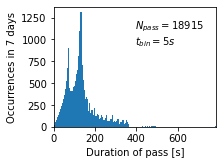

In [49]:
durations_np = pass_df.duration.to_numpy()

fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

bin_size = 5
bins = int(np.max(durations_np))
bins = int(bins / bin_size) # x second bins

n, bins, patches = ax.hist(durations_np, bins=bins, stacked=True)

ax.set_xlabel('Duration of pass [s]')
ax.set_ylabel('Occurrences in 7 days')
ax.set_xlim((0, np.max(durations_np)))

count = len(durations_np)
average = np.average(durations_np)
std_dev = np.std(durations_np)

ax.text(0.5, 0.90,
        '$N_{pass} = %d$\n' % (count) +
        '$t_{bin} = %ds$' % (bin_size),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.show()

Gap duration occurences

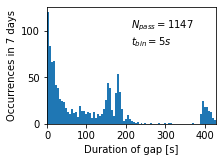

In [52]:
durations_np = gaps_df.duration.to_numpy()

fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

bin_size = 5
bins = int(np.max(durations_np))
bins = int(bins / bin_size) # x second bins

n, bins, patches = ax.hist(durations_np, bins=bins, stacked=True)

ax.set_xlabel('Duration of gap [s]')
ax.set_ylabel('Occurrences in 7 days')
ax.set_xlim((0, np.max(durations_np)))

count = len(durations_np)
average = np.average(durations_np)
std_dev = np.std(durations_np)

ax.text(0.5, 0.90,
        '$N_{pass} = %d$\n' % (count) +
        '$t_{bin} = %ds$' % (bin_size),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.show()

2.000000000003638